In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
base = '/home2/ebrahim/beyond-brainscore/'
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/')
from plotting_functions import plot_across_subjects, plot_test_perf_across_layers, save_fMRI_simple, pass_info_plot_hist2d, find_rows_without_nan
from trained_results_funcs import create_pd_selected_models, find_best, max_across_selected_models
from trained_untrained_results_funcs import max_across_nested
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets
import plotly
import brainio

In [12]:
def find_best_sigma(sigma_range, noL2_str, exp, resultsPath, dataset, perf='pearson_r',
                    lang_indices=None):

        
    sigma_perf_dict = {}
    
    for s in sigma_range:
        
        s = round(s,3)
        
        # load in performance of OASM across voxels/electrodes/ROIs
        OASM_perf =  np.load(f'{resultsPath}/{dataset}_OASM-all-sigma_{s}_1{noL2_str}{exp}.npz')[perf]
        
        OASM_perf = np.nan_to_num(OASM_perf, 0)
        
        # if pereira, take median across language network voxels
        # otherwise simply take the median
        if dataset == 'pereira':
            perf_median = np.median(OASM_perf[lang_indices])
        else:
            perf_median = np.median(OASM_perf)
           
        # make sure it's not nan, happens sometimes when sigma is low 
        # not totally sure why 
        if ~np.isnan(perf_median):
            sigma_perf_dict[s] = perf_median
        
    best_sigma = max(sigma_perf_dict, key=sigma_perf_dict.get)
    
    OASM_perf_best =  np.load(f'{resultsPath}/{dataset}_OASM-all-sigma_{best_sigma}_1{noL2_str}{exp}.npz')[perf]
    OASM_perf_best = np.nan_to_num(OASM_perf_best, 0)
        
    return sigma_perf_dict, best_sigma, OASM_perf_best

def find_best_layer(layer_range, noL2_str, exp, resultsPath, dataset, perf='pearson_r', 
                    lang_indices = None):
    

    layer_perf_dict = {}
    
    for l in layer_range:
    
        layer_perf =  np.load(f'{resultsPath}/{dataset}_gpt2-xl_layer_{l}_1{noL2_str}{exp}.npz')[perf]
        
        layer_perf = np.nan_to_num(layer_perf, nan=0)
        
        if dataset == 'pereira':
            perf_median = np.median(layer_perf[lang_indices])
        else:
            perf_median = np.median(layer_perf)
            
        print(perf_median)
        
        layer_perf_dict[l] = perf_median
            
    best_layer = max(layer_perf_dict, key=layer_perf_dict.get)
    
    layer_perf_best =  np.load(f'{resultsPath}/{dataset}_gpt2-xl_layer_{best_layer}_1{noL2_str}{exp}.npz')[perf]
    layer_perf_best = np.nan_to_num(layer_perf_best, 0)
        
    return layer_perf_dict, best_layer, layer_perf_best       

In [6]:
noL2 = False
shuffled = False
dataset = 'pereira'
exp = None

if noL2:
    noL2_str = '_noL2'
else:
    noL2_str = ''

print(noL2_str)

In [155]:
resultsPath_dataset_nonshuffled = f'/data/LLMs/brainscore/results_{dataset}'
if shuffled:
    resultsPath_dataset = f'/data/LLMs/brainscore/results_{dataset}/shuffled'
else:
    resultsPath_dataset = resultsPath_dataset_nonshuffled
data_processed_folder = f'/data/LLMs/data_processed/{dataset}/dataset'
figurePath = '/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure1/'
default_palette = sns.color_palette('deep')

In [156]:
# load information regarding number of voxels, subjects, and functional network localization for each experiment into a dictionary
if dataset ==  'pereira':

    exp = ['_243', '_384']

    br_labels_dict = {}
    num_vox_dict = {}
    subjects_dict = {}
    for e in exp:

        bre = np.load(f'{data_processed_folder}/networks{e}.npy', allow_pickle=True)
        br_labels_dict[e] = bre
        num_vox_dict[e] = bre.shape[0]
        subjects_dict[e] = np.load(f"{data_processed_folder}/subjects{e}.npy", allow_pickle=True)
    
else:
    subjects_arr  = np.load(f"{data_processed_folder}/subjects{e}.npy", allow_pickle=True)
    
    

In [157]:
sigma_values = np.linspace(0.1, 4.2, 42)

In [159]:
if dataset == 'pereira':
    sigma_perf_dict_384, best_sigma_384, OASM_perf_best_sigma_384 = find_best_sigma(sigma_values, noL2=noL2, exp='384',
                                                    resultsPath=resultsPath_dataset, dataset=dataset)   
    sigma_perf_dict_243, best_sigma_243, OASM_perf_best_sigma_243 = find_best_sigma(sigma_values, noL2=noL2, exp='243',
                                                    resultsPath=resultsPath_dataset, dataset=dataset)
else:
    sigma_perf_dict, best_sigma, OASM_perf_best_sigma = find_best_sigma(sigma_values, noL2_str=noL2_str, exp='', 
                                        resultsPath=resultsPath_dataset, dataset=dataset)

/tmp/ipykernel_1749401/3683624959.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Median pearson r across language voxels')

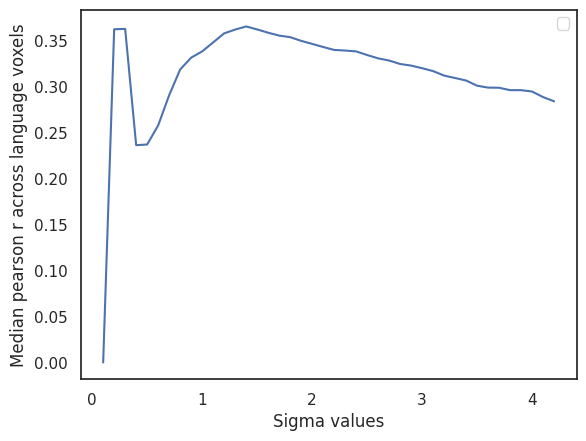

In [160]:
if dataset == 'pereira':
    plt.plot(sigma_perf_dict_384.keys(), sigma_perf_dict_384.values(), label='384')
    plt.plot(sigma_perf_dict_243.keys(), sigma_perf_dict_243.values(), label='243')
else:
    plt.plot(sigma_perf_dict.keys(), sigma_perf_dict.values())
    
plt.legend()
plt.xlabel("Sigma values")
plt.ylabel("Median pearson r across language voxels")

In [162]:
if dataset == 'pereira':
    gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer('gpt2-xl', np.arange(0,49), noL2=noL2, exp='384', 
                                                    resultsPath=resultsPath_dataset, br_labels=br_labels_dict)
    gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer('gpt2-xl', np.arange(0,49), noL2=noL2, exp='243', 
                                                    resultsPath=resultsPath_dataset, br_labels=br_labels_dict)
else:
    gpt2_xl_dict, gpt2_xl_bl, gpt2_xl_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='', 
                            resultsPath=resultsPath_dataset, dataset=dataset)

0.051916336750414654
0.06381855742928075
0.07087480675111762
0.08115310729996193
0.08560207039215584
0.08757088432821547
0.09048802317012744
0.08609922579265773
0.08579717407715529
0.08417055207974045
0.09006349888626083
0.09453488107619006
0.09570479593903568
0.09904847137179856
0.09270375240542378
0.09818712558235577
0.10956836668761674
0.11927801450323947
0.13004806816404477
0.13697122423547206
0.13437689856629312
0.13704958045309468
0.1448435804816724
0.1482388238902366
0.15210655833295908
0.1486912651503539
0.15195538286759705
0.15805576823609394
0.16299961307983651
0.16398216454665368
0.16066617107333933
0.15685536992602395
0.1551072671153144
0.15226722678191715
0.15393077776137104
0.1605462188571297
0.15561645352894315
0.15976037972247398
0.15556699260951762
0.1485032348369154
0.14445476800562154
0.1374200294516448
0.13644812277055524
0.13204215287809207
0.12982679539373537
0.12778417919365054
0.12576098714430373
0.11652349321595395
0.14409150864457843


/tmp/ipykernel_1749401/4093160270.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Median pearson r across language voxels')

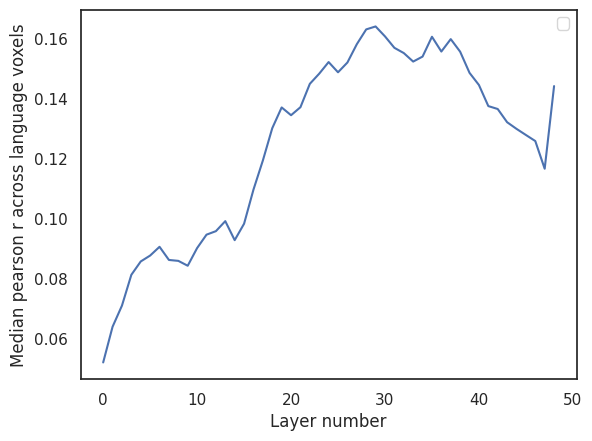

In [163]:
if dataset == 'pereira':
    plt.plot(gpt2_xl_384_dict.keys(), gpt2_xl_384_dict.values(), label='384')
    plt.plot(gpt2_xl_243_dict.keys(), gpt2_xl_243_dict.values(), label='243')
else:
    plt.plot(gpt2_xl_dict.keys(), gpt2_xl_dict.values())
plt.legend()
plt.xlabel("Layer number")
plt.ylabel("Median pearson r across language voxels")

In [164]:
if dataset == 'pereira':
    results_dict_OASM_384 = pd.DataFrame({'perf': OASM_perf_best_sigma_384, 'subjects': subjects_dict['384'], 
                    'Network': br_labels_dict['384'], 'Model': np.repeat('OASM', num_vox_dict['384'])})
    results_dict_OASM_243 = pd.DataFrame({'perf': OASM_perf_best_sigma_243, 'subjects': subjects_dict['243'], 
                    'Network': br_labels_dict['243'], 'Model': np.repeat('OASM', num_vox_dict['243'])})
    results_dict_gpt2_384 = pd.DataFrame({'perf': gpt2_xl_384_bl_perf, 'subjects': subjects_dict['384'], 
                    'Network': br_labels_dict['384'], 'Model': np.repeat('gpt2-xl', num_vox_dict['384'])})
    results_dict_gpt2_243 = pd.DataFrame({'perf': gpt2_xl_243_bl_perf, 'subjects': subjects_dict['243'], 
                    'Network': br_labels_dict['243'], 'Model': np.repeat('gpt2-xl', num_vox_dict['243'])})

    results_OASM_gpt2xl_243 = pd.concat((results_dict_OASM_243, results_dict_gpt2_243))
    results_OASM_gpt2xl_384 = pd.concat((results_dict_OASM_384, results_dict_gpt2_384))
    
else:
    num_brain_units = OASM_perf_best_sigma.shape[0]
    results_dict_OASM = pd.DataFrame({'perf': OASM_perf_best_sigma, 'subjects': subjects_arr, 'Network': np.repeat('language', num_brain_units),
                                      'Model': np.repeat('OASM', num_brain_units)})
    results_dict_gpt2 = pd.DataFrame({'perf': gpt2_xl_bl_perf, 'subjects': subjects_arr, 'Network': np.repeat('language', num_brain_units),
                                      'Model': np.repeat('gpt2-xl', num_brain_units)})
    
    results_OASM_gpt2xl = pd.concat((results_dict_OASM, results_dict_gpt2))

Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

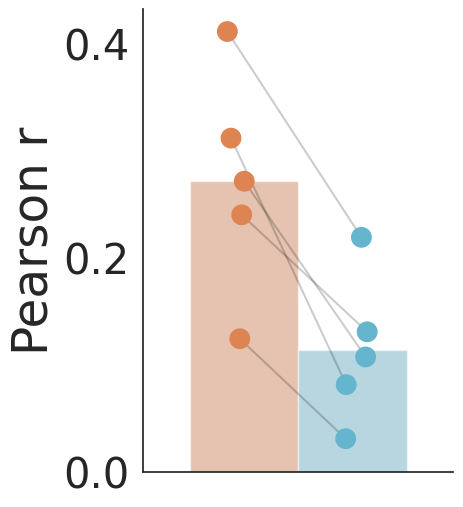

In [169]:
if dataset == 'pereira':
    _, _, _ = plot_across_subjects(results_OASM_gpt2xl_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                                saveName=f'{dataset}_noL2_shufffled_384', 
                                                yticks=[0,0.5], order=['language'], clip_zero=False, color_palette=[default_palette[1], default_palette[9]], 
                                                draw_lines=True, ms=15, plot_legend=True, 
                                                plot_legend_under=False, width=0.7, median=True, ylabel_str='Pearson r')
    
    _, _, _ = plot_across_subjects(results_OASM_gpt2xl_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=f'{dataset}_noL2_shufffled_243', 
                                             yticks=[0,0.5], order=['language'], clip_zero=False, color_palette=[default_palette[1], default_palette[9]], 
                                             draw_lines=True, ms=15, plot_legend=False, 
                                             plot_legend_under=False, width=0.7, median=True, ylabel_str='Pearson r')
else:
    
     _, _, _ = plot_across_subjects(results_OASM_gpt2xl.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=f'{dataset}_{noL2_str}_shufffled', 
                                             yticks=[0,0.2, 0.4], order=['language'], clip_zero=False, color_palette=[default_palette[1], default_palette[9]], 
                                             draw_lines=True, ms=15, plot_legend=False, 
                                             plot_legend_under=False, width=0.7, median=True, ylabel_str='Pearson r')